# Transfer Learning - Part 2: Fine Tuning

- In the **transfer learning part 1**, experimentation was done on feature extraction using the pre-trained models from tensorhub. However, the weights and biases of the pre-trained model were frozen and only the last layer was trained to adjust to the output shape.
- However, in this **fine-tuning transfer learning** the pre-trained model weights and biases will be unfrozen i.e, `trainable= True`. This will better suit the input data to atain higher accuracies.
- This will be achieved by unfreezing one or more layers of the pre-trained model.


## List of experiments to be run:
These are the list of experiments that will help us understand the importance of fine-tuning and will give a path to how to experiment whenever solving a new problem.

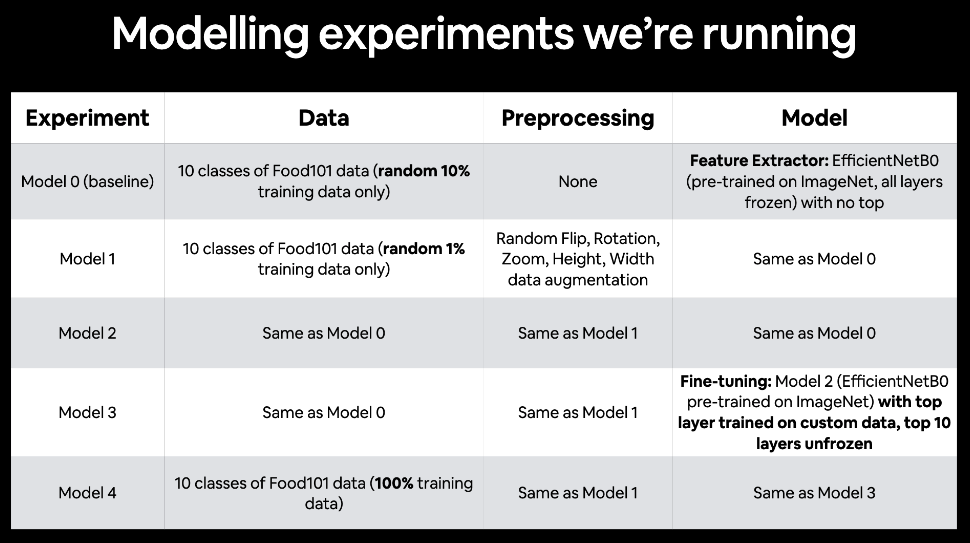

In [1]:
!nvidia-smi

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


Fri Jul  7 18:38:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-07-07 18:38:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-07 18:38:06 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
unzip_data("10_food_classes_10_percent.zip")

In [4]:
walk_through_dir('/content/10_food_classes_10_percent')

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '/content/10_food_classes_10_

In [5]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import datetime
import tensorflow as tf

In [6]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator as idg

# IMAGE_SHAPE = (224, 224)
# BATCH_SIZE = 32

# train_dir = "10_food_classes_10_percent/train/"
# test_dir = "10_food_classes_10_percent/test/"

# image_datagen = idg(rescale=1/255.,
#                                              rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
#                                              shear_range=0.2, # shear the image
#                                              zoom_range=0.2, # zoom into the image
#                                              width_shift_range=0.2, # shift the image width ways
#                                              height_shift_range=0.2, # shift the image height ways
#                                              horizontal_flip=True,
#                     vertical_flip = True)

# print('Training Images')
# train_data_10_percent = image_datagen.flow_from_directory(
#     train_dir,
#     target_size = IMAGE_SHAPE,
#     batch_size = BATCH_SIZE,
#     class_mode= 'categorical',
#     shuffle = True
# )

# print('Testing Images')

# test_data_10_percent = image_datagen.flow_from_directory(
#     test_dir,
#     target_size = IMAGE_SHAPE,
#     class_mode= 'categorical'
# )


##Using `tf.keras.preprocessing.image_dataset_from_directory`

> This allows to directly read the data from the directory and store the names of the classes with much ease and efficiency.


In [7]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory= train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode= 'categorical',
                                                                            batch_size = 32)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir,
                                                                           image_size= IMG_SIZE,
                                                                           label_mode= 'categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent, train_data_10_percent.class_names

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 ['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'])

## Usage of `tf.keras.applications`(Substitube approach for sequential model)
> The most familiar approach use until now are built using `tf.kears.Sequential`, however, there's another approach called **functional**. This approach helps in build more complex and efficient model.

In [9]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224,224,3), name = 'Input Shape')
x = base_model(inputs)
print(f'Shape after base_model: {x.shape}')
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f'After GlobalAveragePooling2d(): {x.shape}')
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)
model_0 = tf.keras.Model(inputs, outputs)
model_0.compile(loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
history_model_0 = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

16705208/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2d(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20230707-183819


Epoch 1/5
24/24 [==============================] - 32s 353ms/step - loss: 1.9249 - accuracy: 0.3987 - val_loss: 1.3167 - val_accuracy: 0.7368
Epoch 2/5
24/24 [==============================] - 4s 135ms/step - loss: 1.1226 - accuracy: 0.7613 - val_loss: 0.8791 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 4s 137ms/step - loss: 0.8028 - accuracy: 0.8253 - val_loss: 0.6927 - val_accuracy: 0.8536
Epoch 4/5
24/24 [==============================] - 4s 146ms/step - loss: 0.6531 - accuracy: 0.8560 - val_loss: 0.5693 - val_accuracy: 0.8799
Epoch 5/5
24/24 [==============================] - 7s 269ms/step - loss: 0.5510 - accuracy: 0.8787 - val_loss: 0.5595 - val_accuracy: 0.8602


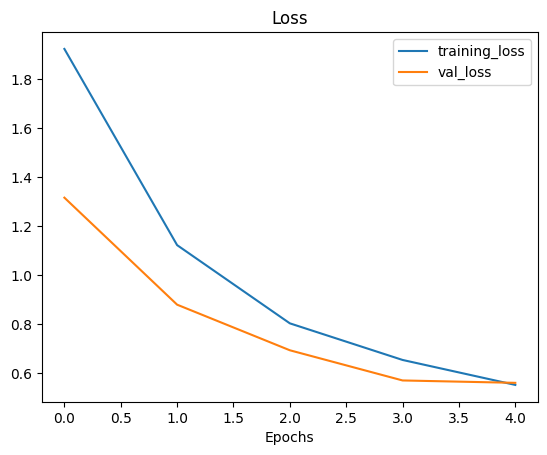

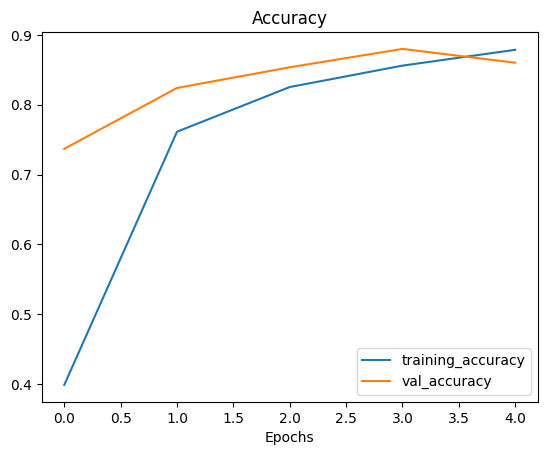

In [10]:
plot_loss_curves(history_model_0)

In [11]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [12]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Shape (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 7s 75ms/step - loss: 0.5520 - accuracy: 0.8660


[0.5520147085189819, 0.8659999966621399]

###Purpose of the GlobalAveragePooling Layer:

>`tf.keras.layers.GlobalAveragePooling2D()` layers transfroms a 4D tensor into 2D tensor by averagng the values across the inner-axes.
Example is denoted in the below cell block.

In [14]:
example_shape = (1,4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(shape = example_shape)
print(f"Random input tensor:\n {input_tensor}\n")

global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooling_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooling_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


Hence, it is observable that the layer has condensed the input tensor by replacing the values with the mean acroos `4,4`. And there by converting the lager vector to smaller `(1,3)` vector. Therefore, `GlobalAveragePooling` Layer is used to reduce the size of the feature vector.

##Time to Run Series of experiments to identify the best model:

Using transfer learning with 10% of the data has shown some incredible results. Time to experiment if the model performs the same in case of just 1% of the data.

1. `model-1`: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

Currently, we are using `EfficientNetB0` is being utilised for all these experimtnets.

**Note:** There is no neccesity to normalise the image data for the EfficientNet models as the nomalisation is built into the model unlike other models such as ResNet.

###Model_1 :
We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the `tf.keras.layers.experimental.preprocessing` module.

In [15]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir_1_percent = "10_food_classes_1_percent/test/"

--2023-07-07 18:39:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 173.194.202.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   139MB/s    in 0.9s    

2023-07-07 18:39:25 (139 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [16]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There a

In [17]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           batch_size = BATCH_SIZE,
                                                                           image_size = IMG_SIZE)
test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                          label_mode = 'categorical',
                                                                          batch_size = BATCH_SIZE,
                                                                          image_size = IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


###Preprocessing & Data Agumentation of the images using `tf.keras.layers.experimental.preprocessing`

>Earlier the images were preprocessed using `ImageDataGenerator`, however now we are going to build the preprocessing into the model itself. Thereby in future anyone using the model, no need invoke preprocessing again, it's done as part of the model.
>`tf.keras.layers.experimental.preprocessing`, enables us to build the preprocessing as a layer in the model.


In [18]:
from tensorflow.keras.layers.experimental import preprocessing

data_agumentation= tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name = 'data_agumentation')

Visualizing the working of the `data_agumentation` layer.

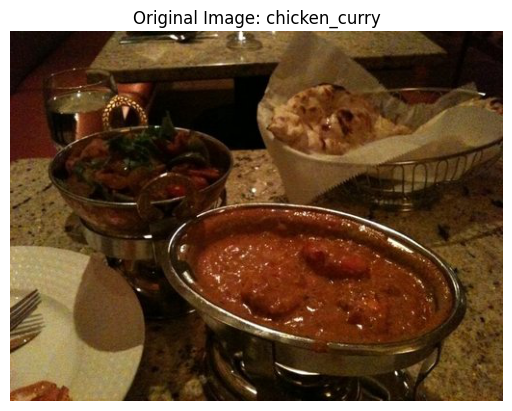

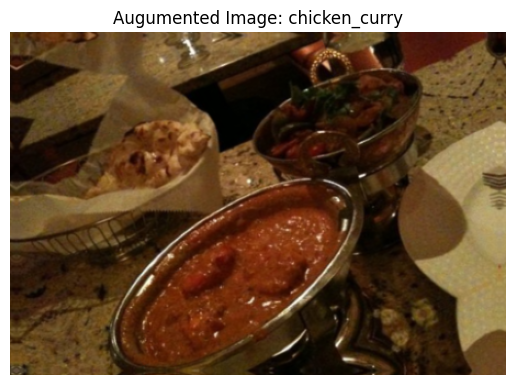

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = train_dir_1_percent + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir+'/'+random_image
img = mping.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original Image: {target_class}')
plt.axis(False);

aug_img = data_agumentation(tf.expand_dims(img, axis= 0)) #Since, this is a layer, it also trys to find the batch number in the input dimension, hence we expand the from 3 dims to 4 dims.
plt.figure()
plt.imshow(tf.squeeze(aug_img)/255) #Since, the agumented image is in the from of 4D tensor we are squeezing it back to 3D to plot image and normalizing it to enable the data reader to understand the image.
plt.title(f'Augumented Image: {target_class}')
plt.axis(False);


### Model-1: Feature Extraction transfer learning from 1% data.

In [20]:
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (IMG_SIZE+(3,)), name = "input_layer")
x = data_agumentation(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'GlobalAveragePooling_Layer')(x)
outputs = tf.keras.layers.Dense(10, activation= 'softmax', name='output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy'])
history_model_1 = model_1.fit(
    train_data_1_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_1_percent),
    validation_data = test_data_1_percent,
    validation_steps = (0.25*len(test_data_1_percent)),
    callbacks = [create_tensorboard_callback("transfer_learning", "1_percent_data_aug")]
)



Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230707-183931
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.3090 - accuracy: 0.1143 - val_loss: 2.1773 - val_accuracy: 0.2359
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0574 - accuracy: 0.3286 - val_loss: 2.0580 - val_accuracy: 0.3469
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.8978 - accuracy: 0.4429 - val_loss: 1.9295 - val_accuracy: 0.4328
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7094 - accuracy: 0.5571 - val_loss: 1.8349 - val_accuracy: 0.4797
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5486 - accuracy: 0.7143 - val_loss: 1.7575 - val_accuracy: 0.5250


In [21]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_agumentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePooling_Layer   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [22]:
model_1_test_data = model_1.evaluate(test_data_1_percent)
model_1_test_data

79/79 [==============================] - 6s 67ms/step - loss: 1.7527 - accuracy: 0.5368


[1.7526822090148926, 0.5368000268936157]

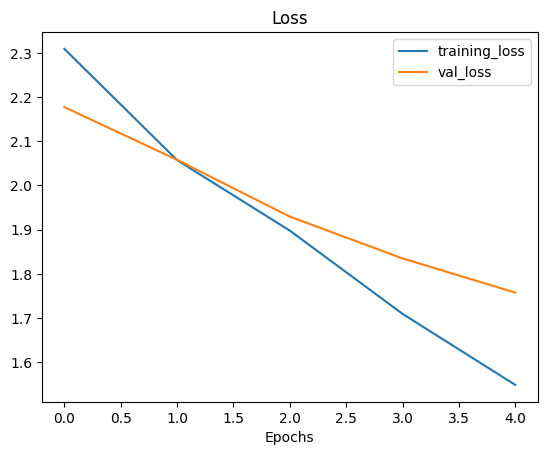

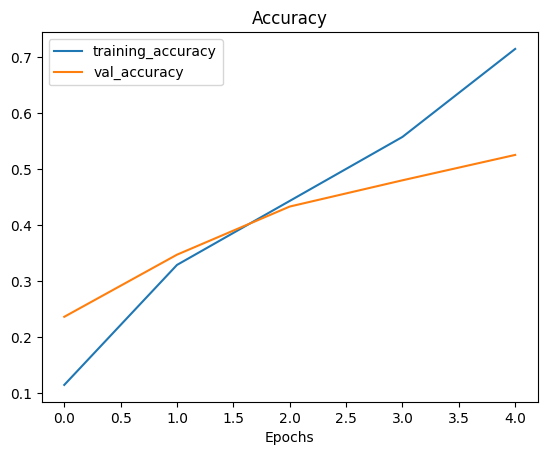

In [23]:
plot_loss_curves(history_model_1)


###Model_2:

Using the 10% of the food data and then also applying the data augumentation to the data. Model remains same, there wont be any changes, it's similar to the Model_1.

In [24]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [25]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode= 'categorical',
    image_size= IMG_SIZE,
    batch_size = BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = 'categorical',
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [26]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = IMG_SIZE+(3,), name = 'input_layer')
x = data_agumentation(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name='Global_Average_Pooling_Layer')(x)
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name= 'output_layer')(x)

model_2 = tf.keras.Model(inputs,outputs)

model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [27]:
from keras.saving.saving_lib import save_weights_only
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                        save_weights_only = True,
                                                        save_best_only = True,
                                                        save_freq = 'epoch',
                                                        verbose = 1)

In [28]:
initial_epochs = 5

history_model_2 = model_2.fit(train_data_10_percent,
                              epochs= initial_epochs,
                              steps_per_epoch = len(train_data_10_percent),
                              validation_data= test_data,
                              validation_steps = int(0.25*len(test_data)),
                              callbacks = [create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), checkpoint_callback]
                              )

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230707-184022


Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9266 - accuracy: 0.3907
Epoch 1: val_loss improved from inf to 1.36088, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 35s 763ms/step - loss: 1.9266 - accuracy: 0.3907 - val_loss: 1.3609 - val_accuracy: 0.7122
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2582 - accuracy: 0.7240
Epoch 2: val_loss improved from 1.36088 to 0.97727, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 514ms/step - loss: 1.2582 - accuracy: 0.7240 - val_loss: 0.9773 - val_accuracy: 0.7796
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9720 - accuracy: 0.7920
Epoch 3: val_loss improved from 0.97727 to 0.78410, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 529ms/step - loss: 0.9720 - accuracy: 0.7920 - val

In [29]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 68ms/step - loss: 0.6103 - accuracy: 0.8484


[0.6102650761604309, 0.8483999967575073]

<Axes: >

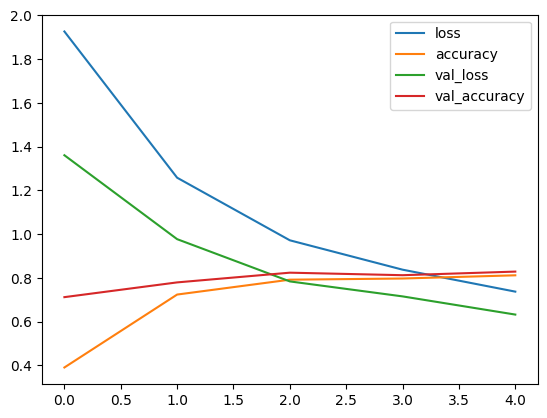

In [30]:
pd.DataFrame(history_model_2.history).plot()

 load saved model weights you can use the the `load_weights() `
 method

In [31]:
model_2.load_weights(checkpoint_path)

loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 87ms/step - loss: 0.6103 - accuracy: 0.8484


let's compare the results of our previously trained model and the loaded model.

In [32]:
results_10_percent_data_aug == loaded_weights_model_results


False


If the above cell doesn't output True, it's because the numbers are close but not the exact same (due to how computers store numbers with degrees of precision).

###Model_3:
In the previous model all the layers are set to non-trainable in the base model. Now we are gonna unfreeze some of them.

In [33]:
model_2.layers

In [34]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


So this shows that all the layers are trainable except the efficiennetBO layers. Now let's go ahead and unfreeze top 10 of those layers.(when i am saying top, it means the layers closer to the ouput.)

In [35]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

# Here we are directly using the model_2 from where we left off to notice the changes these updates will bring
# Furthermore, when you are using pre-trained model layers to further train always use a lower learning rate. By default its 0.001
# We are gonna 10x lower that, so the lr = 0.0001

model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ['accuracy']
)

Now, lets see if the last 10 layers are changed to trainable.

In [36]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

Yes, only the last ten layers are trainable

In [37]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_model_2.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230707-184211


Epoch 5/10
24/24 [==============================] - 24s 535ms/step - loss: 0.6300 - accuracy: 0.8160 - val_loss: 0.5296 - val_accuracy: 0.8257
Epoch 6/10
24/24 [==============================] - 12s 501ms/step - loss: 0.4959 - accuracy: 0.8440 - val_loss: 0.4769 - val_accuracy: 0.8438
Epoch 7/10
24/24 [==============================] - 11s 418ms/step - loss: 0.4225 - accuracy: 0.8640 - val_loss: 0.4841 - val_accuracy: 0.8372
Epoch 8/10
24/24 [==============================] - 13s 540ms/step - loss: 0.3783 - accuracy: 0.8907 - val_loss: 0.4729 - val_accuracy: 0.8503
Epoch 9/10
24/24 [==============================] - 11s 423ms/step - loss: 0.3348 - accuracy: 0.9080 - val_loss: 0.4832 - val_accuracy: 0.8372
Epoch 10/10
24/24 [==============================] - 10s 416ms/step - loss: 0.3211 - accuracy: 0.9040 - val_loss: 0.4748 - val_accuracy: 0.8339


In [38]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.4126 - accuracy: 0.8636


In [39]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.390666663646698, 0.7239999771118164, 0.7919999957084656, 0.7973333597183228, 0.8119999766349792, 0.8159999847412109, 0.843999981880188, 0.8640000224113464, 0.890666663646698, 0.9079999923706055, 0.9039999842643738]


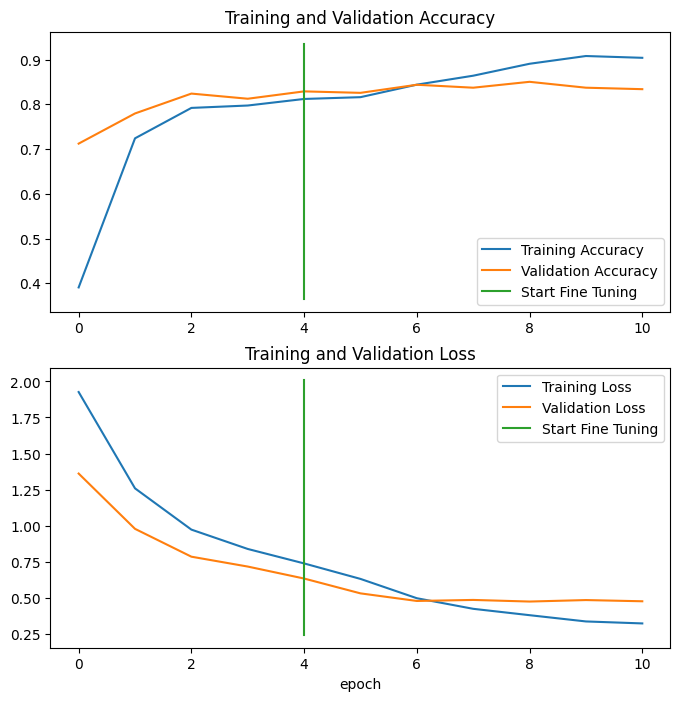

In [40]:
compare_historys(original_history=history_model_2,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

###Model_4:
Use the full dataset

In [41]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-07-07 18:43:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  39.0MB/s    in 10s     

2023-07-07 18:44:00 (49.4 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [42]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.

In [43]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE
                                                                                 batch_size= BATCH_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size= BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [44]:
model_2.evaluate(test_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.4126 - accuracy: 0.8636


[0.41258373856544495, 0.8636000156402588]

In [45]:
results_10_percent_data_aug


[0.6102650761604309, 0.8483999967575073]

In [46]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

In [48]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_model_2.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230707-184835


Epoch 5/10
235/235 [==============================] - 62s 261ms/step - loss: 0.5068 - accuracy: 0.8345 - val_loss: 0.3011 - val_accuracy: 0.8914
Epoch 6/10
235/235 [==============================] - 58s 245ms/step - loss: 0.4547 - accuracy: 0.8565 - val_loss: 0.2914 - val_accuracy: 0.9013
Epoch 7/10
235/235 [==============================] - 63s 263ms/step - loss: 0.4030 - accuracy: 0.8715 - val_loss: 0.2711 - val_accuracy: 0.9062
Epoch 8/10
235/235 [==============================] - 49s 207ms/step - loss: 0.3722 - accuracy: 0.8820 - val_loss: 0.2730 - val_accuracy: 0.8997
Epoch 9/10
235/235 [==============================] - 46s 194ms/step - loss: 0.3432 - accuracy: 0.8857 - val_loss: 0.2574 - val_accuracy: 0.9128
Epoch 10/10
235/235 [==============================] - 44s 185ms/step - loss: 0.3157 - accuracy: 0.8955 - val_loss: 0.2601 - val_accuracy: 0.9145


In [49]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 9s 94ms/step - loss: 0.2697 - accuracy: 0.9128


[0.2697463035583496, 0.9128000140190125]

5
11
[0.390666663646698, 0.7239999771118164, 0.7919999957084656, 0.7973333597183228, 0.8119999766349792, 0.8345333337783813, 0.8565333485603333, 0.8714666962623596, 0.8820000290870667, 0.8857333064079285, 0.895466685295105]


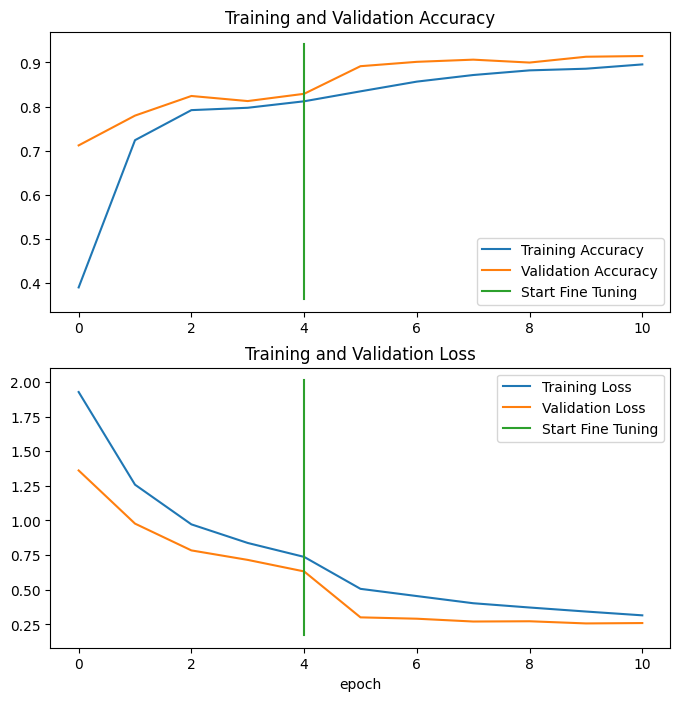

In [52]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_model_2,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

In [ ]:
model_2.predi

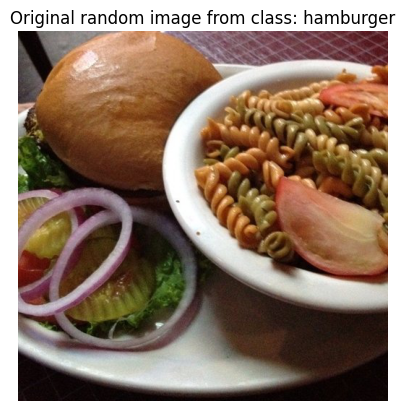

In [88]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes


In [89]:
test_img = tf.image.resize(img, size = IMG_SIZE)
predicted_img = model_2.predict(tf.expand_dims(test_img, axis=0))
a = int(tf.math.argmax(predicted_img, axis = 1).numpy())
print(f"Predicted class: {train_data_1_percent.class_names[a]}")

1/1 [==============================] - 0s 43ms/step
Predicted class: hamburger
